# Importation des librairies

Pour simplifier et faire l'analyse des données EEG nous aurons besoin de plusieurs

**Pandas**: Permet d'importer le fichier EEG comme un objet "DataFrame" qui fonctionne comme un tableau csv (excel), mais plus facile à manipuler, on peut cleaner le data pour garder que ce qui est utile

**matplotlib**: Permet d'affichier des graphiques

**MNE**: https://mne.tools/stable/auto_tutorials/intro/10_overview.html permet d'appliquer des filtres facilement sur les signaux EEG

**Numpy**: https://numpy.org/doc/stable/user/ permet d'avoir des "Arrays" plutot que des liste dans python.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mne


In [2]:
droite = pd.read_csv("droite.txt", skiprows=4)
gauche = pd.read_csv("gauche.txt", skiprows=4)
avancer = pd.read_csv("avancer.txt", skiprows=4)
reculer = pd.read_csv("reculer.txt", skiprows=4)

In [3]:
droite.head()

,Sample Index,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3,Accel Channel 0,Accel Channel 1,Accel Channel 2,Other,Other.1,Other.2,Other.3,Other.4,Timestamp,Marker Channel,Timestamp (Formatted)
0,0.0,-2189.406622,-2233.645899,-2080.293171,-1919.851463,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,1.749061e+09,0.0,2025-06-04 14:22:12.192
1,1.0,-2198.374902,-2235.437311,-2086.482705,-1896.361151,0.000,-0.176,0.0,0.0,0.0,0.0,0.0,0.0,1.749061e+09,0.0,2025-06-04 14:22:12.205
2,1.0,-2198.655395,-2241.316434,-2090.162767,-1944.871394,0.000,-0.176,0.0,0.0,0.0,0.0,0.0,0.0,1.749061e+09,0.0,2025-06-04 14:22:12.205
3,2.0,-2198.472140,-2240.400158,-2085.297157,-1923.931694,-0.016,-0.176,0.0,0.0,0.0,0.0,0.0,0.0,1.749061e+09,0.0,2025-06-04 14:22:12.222
4,2.0,-2193.636449,-2236.200250,-2082.387515,-1914.092017,-0.016,-0.176,0.0,0.0,0.0,0.0,0.0,0.0,1.749061e+09,0.0,2025-06-04 14:22:12.222


In [4]:
def get_marker(marker):
    if marker == 1.875:
        return 'active'
    elif marker == 2.0:
        return 'repos'

In [5]:
droite['Status'] = droite[' Marker Channel'].apply(get_marker)
gauche['Status'] = gauche[' Marker Channel'].apply(get_marker)
avancer['Status'] = avancer[' Marker Channel'].apply(get_marker)
reculer['Status'] = reculer[' Marker Channel'].apply(get_marker)
#Ajoute une nouvelle colonne "Status"

In [6]:
droite = droite.drop(columns=[' Accel Channel 0', ' Accel Channel 1', ' Accel Channel 2', ' Other.1', ' Other.2', ' Other.3', ' Other.4', ' Other', ' Timestamp (Formatted)',' Marker Channel'])

In [7]:
droite.head()

,Sample Index,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3,Timestamp,Status
0,0.0,-2189.406622,-2233.645899,-2080.293171,-1919.851463,1.749061e+09,None
1,1.0,-2198.374902,-2235.437311,-2086.482705,-1896.361151,1.749061e+09,None
2,1.0,-2198.655395,-2241.316434,-2090.162767,-1944.871394,1.749061e+09,None
3,2.0,-2198.472140,-2240.400158,-2085.297157,-1923.931694,1.749061e+09,None
4,2.0,-2193.636449,-2236.200250,-2082.387515,-1914.092017,1.749061e+09,None


In [10]:
def extract_active_epochs(df, sample_rate, active_duration, repos_duration):
    sampling_rate = sample_rate  # Hz
    active_epoch_duration = active_duration  # secondes
    repos_epoch_duration = repos_duration
    
    active_samples_par_epoch = active_epoch_duration * sampling_rate
    repos_samples_par_epoch = repos_epoch_duration * sampling_rate
    
    active_indices = df[df['Status'] == 'active'].index
    
    active_epochs = []
    
    i = 0
    while i < len(active_indices):
        start = active_indices[i]
        end = start + active_samples_par_epoch
        epoch = df.iloc[start:end]
        epoch.drop(columns=['Status'])
        active_epochs.append(epoch)
        i += 1

    return active_epochs

In [11]:
droite = extract_active_epochs(droite, 200, 10, 5)
gauche = extract_active_epochs(gauche, 200, 10, 5)
avancer = extract_active_epochs(avancer, 200, 10, 5)
reculer = extract_active_epochs(reculer, 200, 10, 5)

In [12]:
print(len(droite))
print(len(gauche))
print(len(avancer))
print(len(reculer))

10
10
10
10


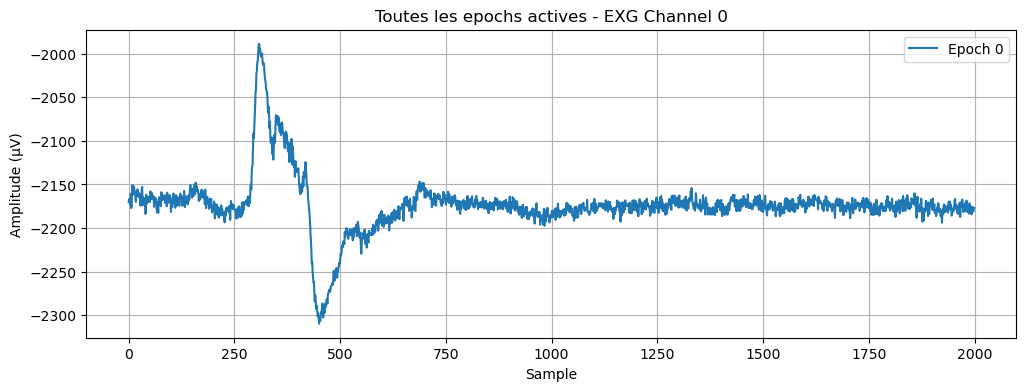

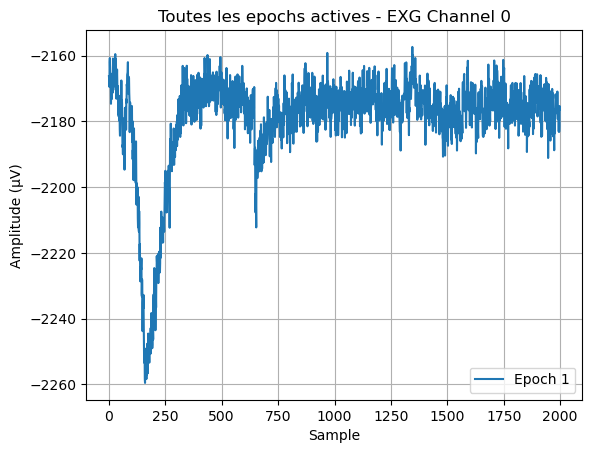

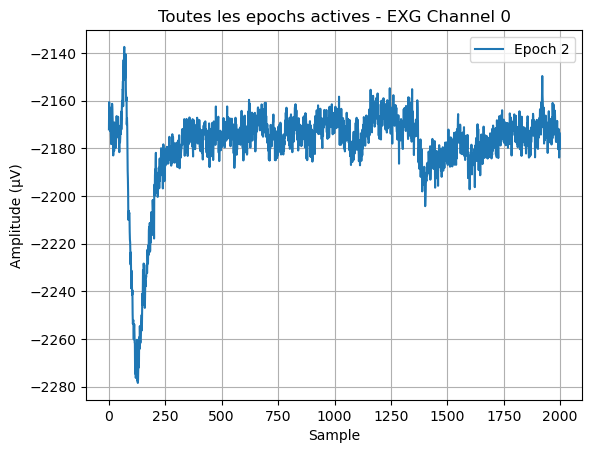

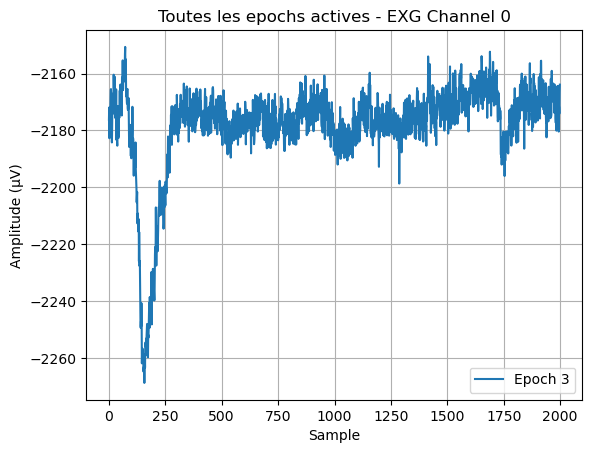

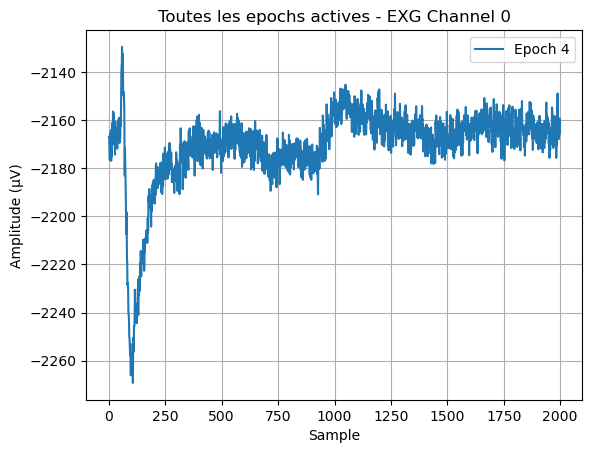

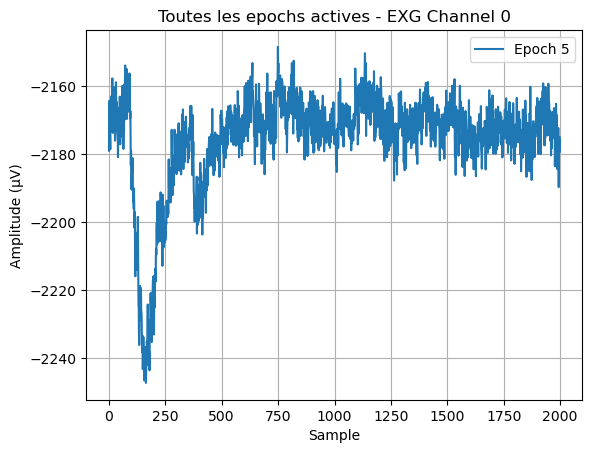

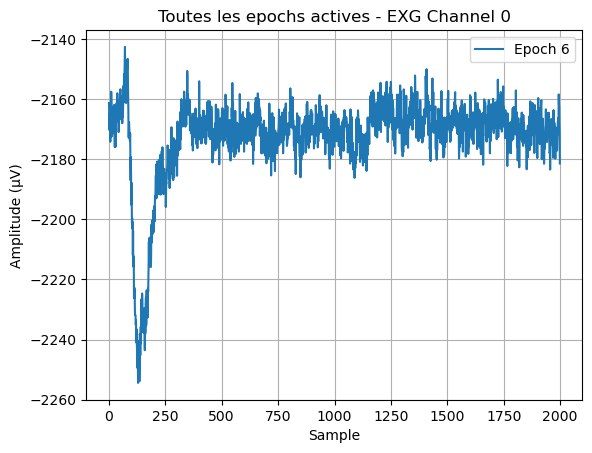

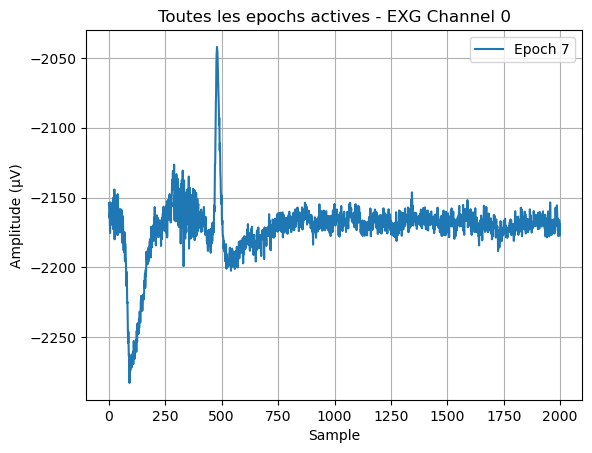

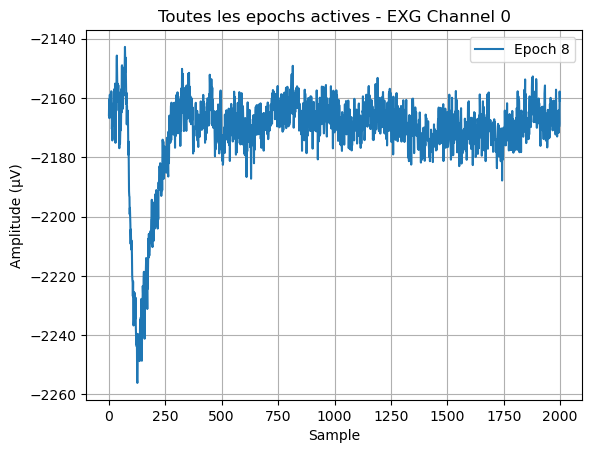

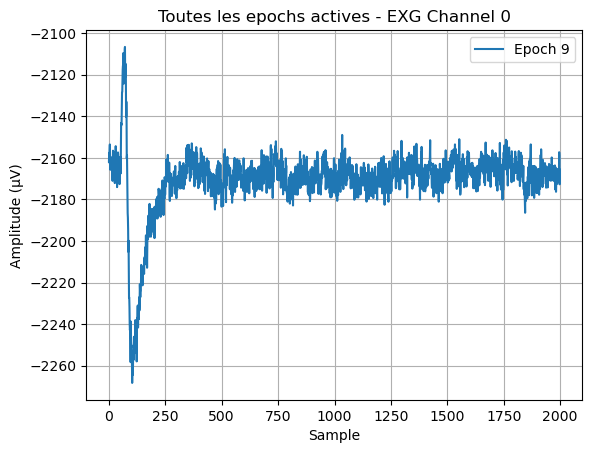

In [18]:
plt.figure(figsize=(12, 4))
for i, epoch in enumerate(droite):
    plt.plot(epoch[' EXG Channel 0'].values, label=f"Epoch {i}")
    plt.title("Toutes les epochs actives - EXG Channel 0")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude (µV)")
    plt.legend()
    plt.grid()
    plt.show()

In [14]:
def extraire_features(epoch, channels):
    data = epoch[channels].to_numpy()
    moyennes = np.mean(data, axis=0)
    ecarts_type = np.std(data, axis=0)
    puissances = np.mean(data**2, axis=0)
    return np.concatenate([moyennes, ecarts_type, puissances])

In [15]:
channels = [" EXG Channel 0", " EXG Channel 1", " EXG Channel 2", " EXG Channel 3"]
test = extraire_features(droite[0], channels)

In [16]:
print(test)

[-2.17346974e+03 -2.20518348e+03 -2.06337969e+03 -1.89135057e+03
  3.28421300e+01  3.09633642e+01  7.64833453e+00  9.63744385e+00
  4.72504929e+06  4.86379292e+06  4.25759425e+06  3.57729984e+06]


In [19]:
# comparer les epoches similitudes, seconde par seconde
# comparaison de series temporelles ** classer multi modale
# gauche droite

